In [5]:
# Streaming LSTM Autoencoder (Parameter Sweep Version)

import os, time, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from collections import deque

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
import tensorflow as tf

# Configuration
DATA_DIR = "generated_datasets"
RESULTS_DIR = "results_streaming"
os.makedirs(RESULTS_DIR, exist_ok=True)

WINDOW_SIZE = 30
LATENT_DIM = 32
EPOCHS = 3
CONTAMINATION = 0.05
RETRAIN_INTERVAL = 5000

In [21]:
# User-defined for single run
BATCH_SIZE = 500
BUFFER_RATIO = 3
SEED = 1

np.random.seed(SEED)
tf.random.set_seed(SEED)

INITIAL_TRAIN_SIZE = BUFFER_RATIO * WINDOW_SIZE

In [9]:
# Build LSTM Autoencoder
def build_model(window_size):
    input_layer = Input(shape=(window_size, 1))
    encoded = LSTM(LATENT_DIM, activation='relu')(input_layer)
    decoded = RepeatVector(window_size)(encoded)
    decoded = LSTM(LATENT_DIM, activation='relu', return_sequences=True)(decoded)
    output = TimeDistributed(Dense(1))(decoded)
    return Model(inputs=input_layer, outputs=output)

# Create overlapping sequences
def create_sequences(data, window_size):
    return np.array([data[i:i + window_size] for i in range(len(data) - window_size)])

# Create overlapping sequences
def run_streaming_lstm(ts_scaled):
    start_time = time.time()

    buffer = deque(ts_scaled[:INITIAL_TRAIN_SIZE], maxlen=INITIAL_TRAIN_SIZE)
    scores = []

    # Initial training
    model = build_model(WINDOW_SIZE)
    model.compile(optimizer='adam', loss='mse')
    initial_train = create_sequences(np.array(buffer), WINDOW_SIZE).reshape((-1, WINDOW_SIZE, 1))
    model.fit(initial_train, initial_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

    # Create prediction windows
    all_windows = create_sequences(ts_scaled, WINDOW_SIZE).reshape((-1, WINDOW_SIZE, 1))
    preds = model.predict(all_windows, verbose=0)
    errors = np.mean((all_windows - preds) ** 2, axis=(1, 2))
    scores = [0.0] * WINDOW_SIZE + list(errors)

    # Retraining periodically
    for i in range(INITIAL_TRAIN_SIZE, len(ts_scaled), RETRAIN_INTERVAL):
        if i + RETRAIN_INTERVAL >= len(ts_scaled):
            break
        buffer.extend(ts_scaled[i:i + RETRAIN_INTERVAL])
        retrain_seq = create_sequences(np.array(buffer), WINDOW_SIZE).reshape((-1, WINDOW_SIZE, 1))
        model.fit(retrain_seq, retrain_seq, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

    elapsed = time.time() - start_time
    return np.array(scores[:len(ts_scaled)]), elapsed


Processing normality_1_daphnet.npy (Batch Size=500, Buffer Ratio=3, Seed=1)
Precision: 0.131, Recall: 0.057, F1: 0.080, AUC: 0.538, Time: 150.10s


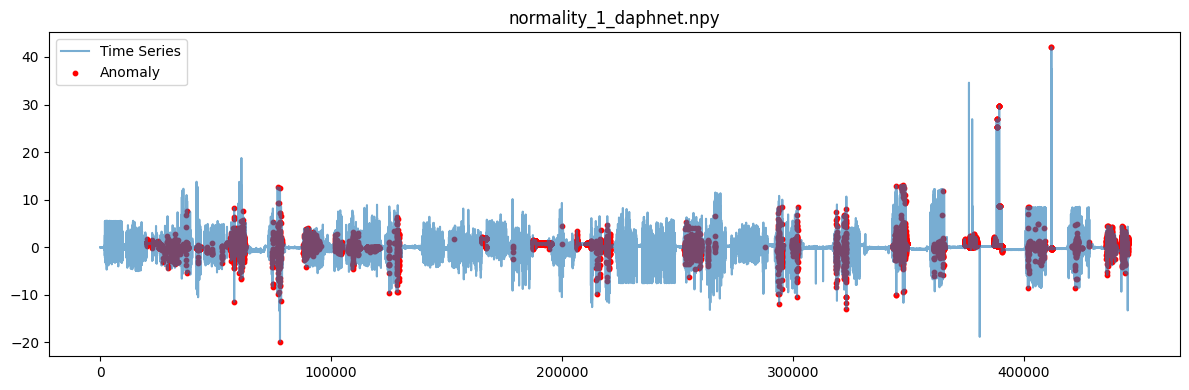


Processing normality_1_genesis.npy (Batch Size=500, Buffer Ratio=3, Seed=1)
Precision: 0.000, Recall: 0.000, F1: 0.000, AUC: 0.199, Time: 14.30s


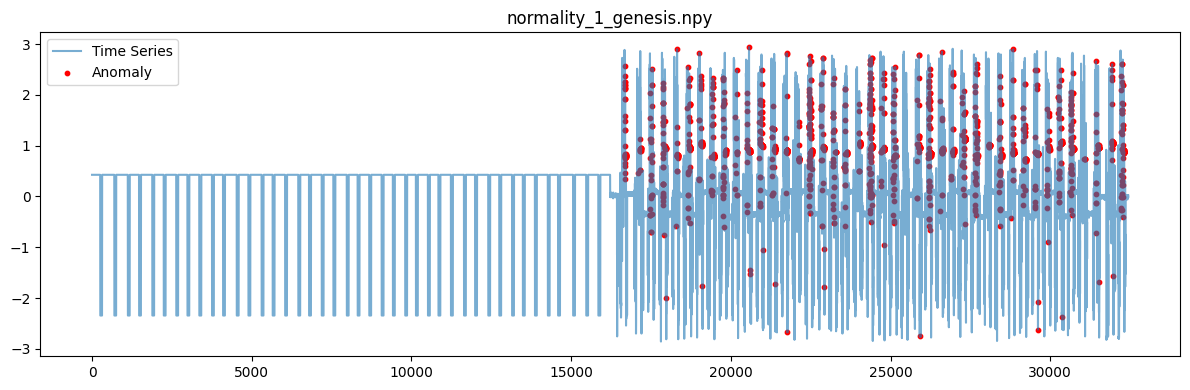


Processing normality_1_nasa-msl.npy (Batch Size=500, Buffer Ratio=3, Seed=1)
Precision: 0.228, Recall: 0.186, F1: 0.205, AUC: 0.599, Time: 37.73s


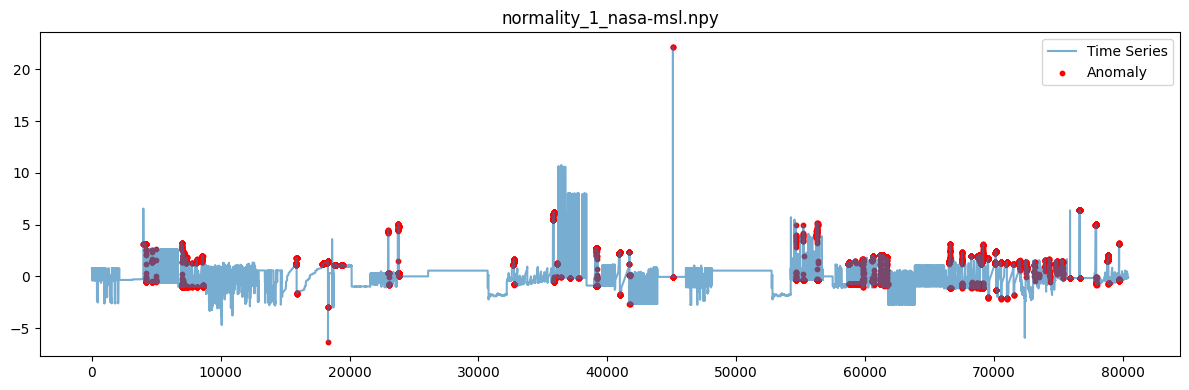


Processing normality_2_1_daphnet_genesis.npy (Batch Size=500, Buffer Ratio=3, Seed=1)
Precision: 0.117, Recall: 0.055, F1: 0.075, AUC: 0.530, Time: 151.57s


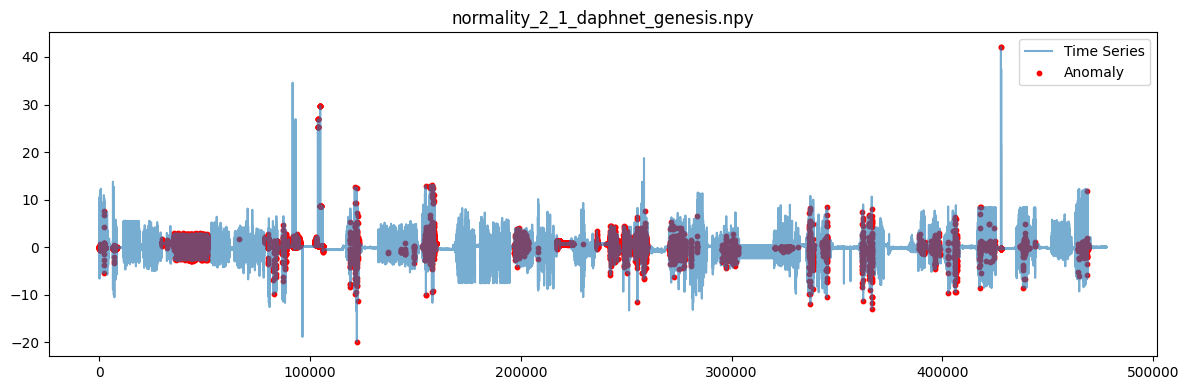


Processing normality_2_2_daphnet_nasa-msl.npy (Batch Size=500, Buffer Ratio=3, Seed=1)
Precision: 0.147, Recall: 0.069, F1: 0.094, AUC: 0.539, Time: 184.18s


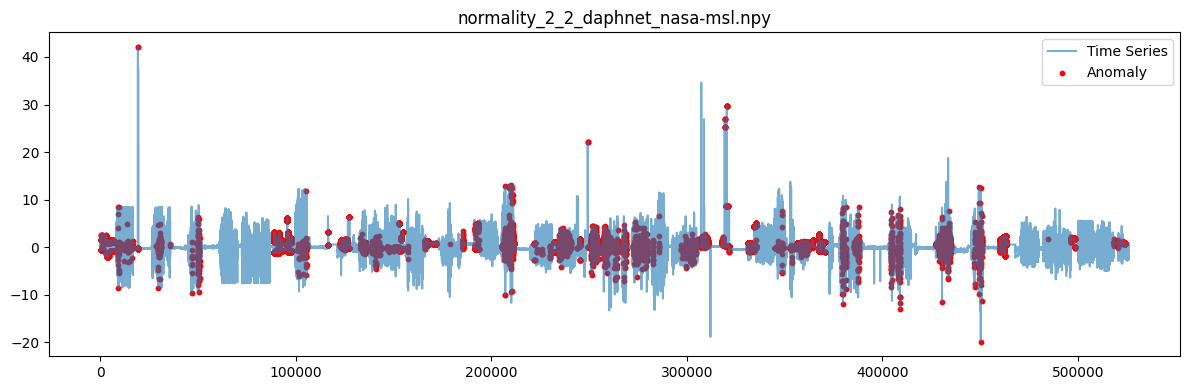


Processing normality_2_3_genesis_nasa-msl.npy (Batch Size=500, Buffer Ratio=3, Seed=1)
Precision: 0.153, Recall: 0.171, F1: 0.161, AUC: 0.582, Time: 46.10s


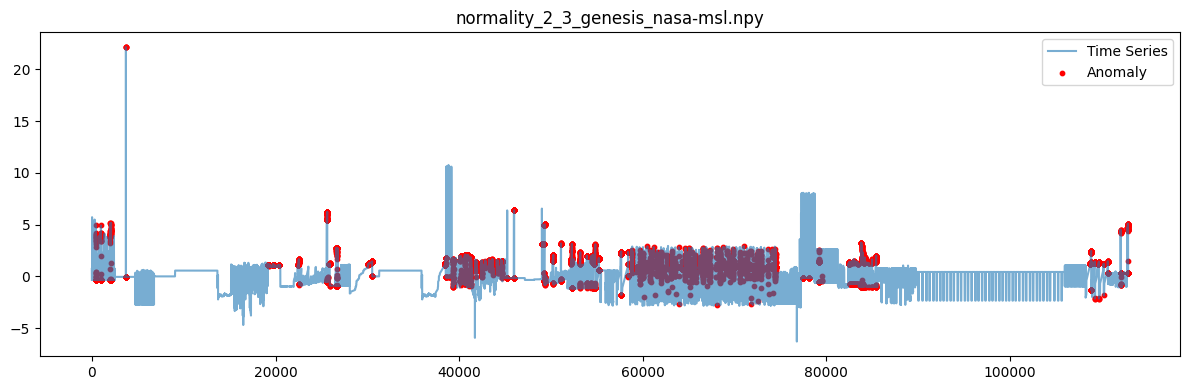


Processing normality_3_1_daphnet_genesis_nasa-msl.npy (Batch Size=500, Buffer Ratio=3, Seed=1)
Precision: 0.121, Recall: 0.061, F1: 0.081, AUC: 0.533, Time: 197.68s


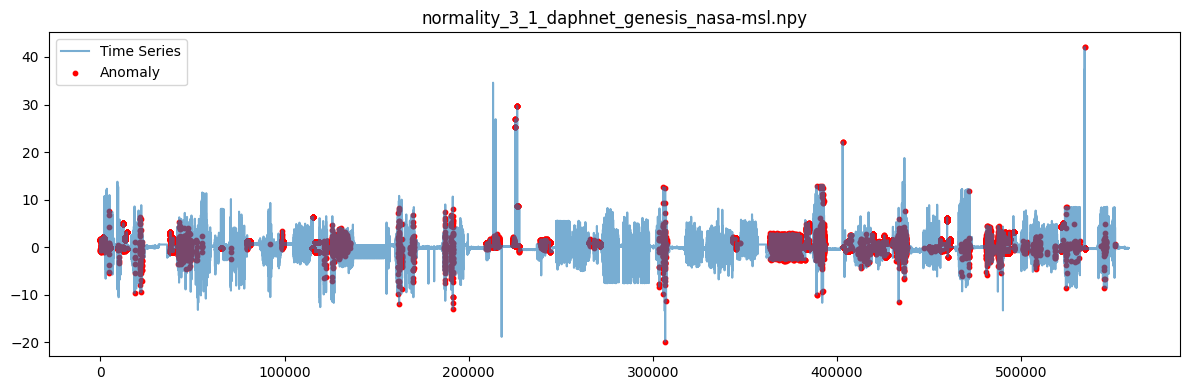


Processing normality_3_2_genesis_nasa-msl_daphnet.npy (Batch Size=500, Buffer Ratio=3, Seed=1)
Precision: 0.121, Recall: 0.061, F1: 0.081, AUC: 0.532, Time: 168.75s


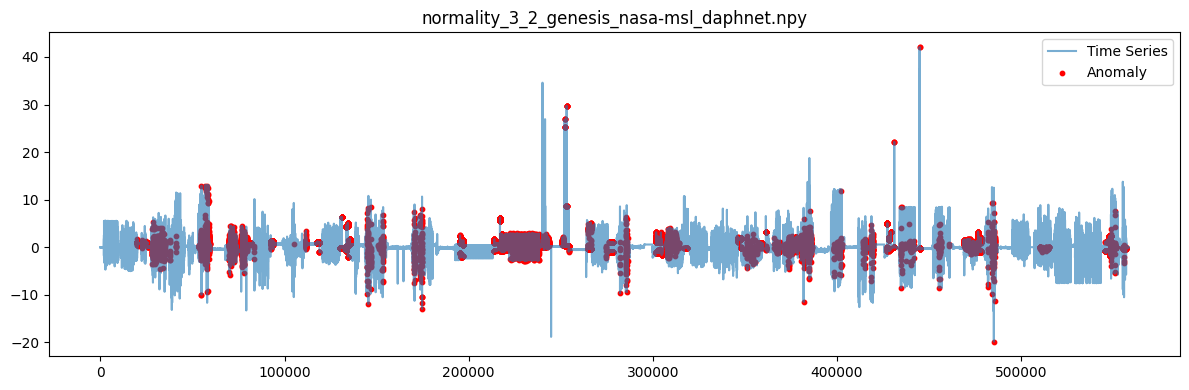


Processing normality_3_3_nasa-msl_daphnet_genesis.npy (Batch Size=500, Buffer Ratio=3, Seed=1)
Precision: 0.122, Recall: 0.061, F1: 0.082, AUC: 0.533, Time: 205.82s


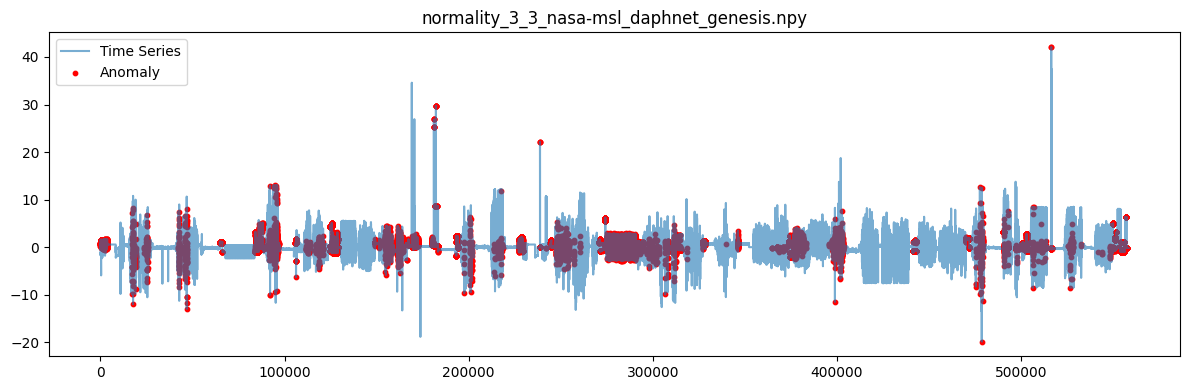

In [22]:
# Run full evaluation
summary = []

for fname in sorted(os.listdir(DATA_DIR)):
    if not fname.endswith(".npy") or "_labels" in fname or "_boundaries" in fname:
        continue

    print(f"\nProcessing {fname} (Batch Size={BATCH_SIZE}, Buffer Ratio={BUFFER_RATIO}, Seed={SEED})")
    ts_path = os.path.join(DATA_DIR, fname)
    label_path = ts_path.replace(".npy", "_labels.npy")

    if not os.path.exists(label_path):
        print(f"Skipping {fname}, missing labels.")
        continue

    raw_ts = np.load(ts_path)
    labels = np.load(label_path)

    if len(raw_ts) < INITIAL_TRAIN_SIZE + WINDOW_SIZE:
        print("Skipped: Too short for streaming processing")
        continue

    scaler = MinMaxScaler()
    ts_scaled = scaler.fit_transform(raw_ts.reshape(-1, 1)).flatten()

    scores, runtime = run_streaming_lstm(ts_scaled)
    threshold = np.percentile(scores, 100 * (1 - CONTAMINATION))
    preds = (scores > threshold).astype(int)

    y_true = labels[:len(preds)]

    # Evaluation
    p = precision_score(y_true, preds, zero_division=0)
    r = recall_score(y_true, preds, zero_division=0)
    f = f1_score(y_true, preds, zero_division=0)
    a = roc_auc_score(y_true, scores) if len(set(y_true)) > 1 else 0.0

    print(f"Precision: {p:.3f}, Recall: {r:.3f}, F1: {f:.3f}, AUC: {a:.3f}, Time: {runtime:.2f}s")

    # Visualization
    plt.figure(figsize=(12, 4))
    plt.plot(raw_ts, label="Time Series", alpha=0.6)
    anomaly_idx = np.where(preds == 1)[0]
    plt.scatter(anomaly_idx, raw_ts[anomaly_idx], color='red', s=10, label="Anomaly")
    plt.title(fname)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, fname.replace(".npy", ".png")))
    plt.show()
    plt.close()

    summary.append(dict(dataset=fname, length=len(raw_ts),
                        precision=round(p, 3), recall=round(r, 3),
                        f1=round(f, 3), auc=round(a, 3), time=round(runtime, 2)))

In [23]:
if summary:
    df = pd.DataFrame(summary).set_index("dataset")
    display(df)
    df.to_csv(os.path.join(RESULTS_DIR, "streaming_lstm_v2_results_500.csv"))
else:
    print("No datasets were successfully processed.")

,length,precision,recall,f1,auc,time
dataset,,,,,,
normality_1_daphnet.npy,445440,0.131,0.057,0.080,0.538,150.10
normality_1_genesis.npy,32440,0.000,0.000,0.000,0.199,14.30
normality_1_nasa-msl.npy,80427,0.228,0.186,0.205,0.599,37.73
normality_2_1_daphnet_genesis.npy,477880,0.117,0.055,0.075,0.530,151.57
normality_2_2_daphnet_nasa-msl.npy,525867,0.147,0.069,0.094,0.539,184.18
normality_2_3_genesis_nasa-msl.npy,112867,0.153,0.171,0.161,0.582,46.10
normality_3_1_daphnet_genesis_nasa-msl.npy,558307,0.121,0.061,0.081,0.533,197.68
normality_3_2_genesis_nasa-msl_daphnet.npy,558307,0.121,0.061,0.081,0.532,168.75
normality_3_3_nasa-msl_daphnet_genesis.npy,558307,0.122,0.061,0.082,0.533,205.82
